##Задание 1

Написать теггер на данных с русским языком

1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбмнации
2. написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов
3. сравнить все реализованные методы сделать выводы


Начнем с 

**1**. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбмнации

In [ ]:
!pip install pyconll

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyconll

!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

--2022-06-19 10:42:58--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40736565 (39M) [text/plain]
Saving to: ‘ru_syntagrus-ud-train-a.conllu’

ru_syntagrus-ud-tra 100%[===================>]  38.85M   158MB/s    in 0.2s    

2022-06-19 10:43:02 (158 MB/s) - ‘ru_syntagrus-ud-train-a.conllu’ saved [40736565/40736565]

--2022-06-19 10:43:02--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199

In [ ]:
full_train = pyconll.load_from_file('/content/ru_syntagrus-ud-train-a.conllu')
full_test = pyconll.load_from_file('/content/ru_syntagrus-ud-dev.conllu')

In [ ]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])
    
fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])
    
fdata_sent_test = []
for sent in full_test[:]:
    for word in sent:
        fdata_sent_test.append(word.form)

In [ ]:
MAX_SENT_LEN = max(len(sent) for sent in full_train)
MAX_ORIG_TOKEN_LEN = max(len(token.form) for sent in full_train for token in sent)
print('Наибольшая длина предложения', MAX_SENT_LEN)
print('Наибольшая длина токена', MAX_ORIG_TOKEN_LEN)

Наибольшая длина предложения 194
Наибольшая длина токена 31


In [ ]:
import nltk
from nltk.tag import DefaultTagger
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger, TrigramTagger
from nltk.tag import RegexpTagger

In [ ]:
unigram_tagger = UnigramTagger(fdata_train)

In [ ]:
unigram_tagger.evaluate(fdata_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  """Entry point for launching an IPython kernel.


0.823732013802982

In [ ]:
bigram_tagger = BigramTagger(fdata_train, backoff=unigram_tagger)
bigram_tagger.evaluate(fdata_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


0.8292792499511688

In [ ]:
trigram_tagger = TrigramTagger(fdata_train, backoff=unigram_tagger)
trigram_tagger.evaluate(fdata_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


0.828550035809623

In [ ]:
trigram_tagger = TrigramTagger(fdata_train, backoff=bigram_tagger)
trigram_tagger.evaluate(fdata_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  


0.8291425222996289

In [ ]:
def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff


backoff = DefaultTagger('NN') 
tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, BigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
tag.evaluate(fdata_test) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  if sys.path[0] == '':


0.827905462595221

По итогу, лучше всех справился BigramTagger

**2. Написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов**

In [ ]:
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])
        
test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)

In [ ]:
le.classes_

array(['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
       'NO_TAG', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM',
       'VERB', 'X'], dtype='<U6')

Сначала попробуем символьный char (от 1 до 4) vectoraizer

In [ ]:
hvectorizer = HashingVectorizer(ngram_range=(1, 4), analyzer='char', n_features=100)

In [ ]:
for number, element in enumerate(test_tok):
    if element == None:
        test_tok[number] = 'Пустышка'

In [ ]:
X_train = hvectorizer.fit_transform(train_tok)
X_test = hvectorizer.transform(test_tok)

X_train.shape

(426182, 100)

In [ ]:
import xgboost
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

In [ ]:
xgb_model.fit(X_train, train_enc_labels)

XGBClassifier(objective='multi:softprob')

In [ ]:
pred = xgb_model.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
test_enc_labels = le.fit_transform(test_label)

print(classification_report(test_enc_labels, pred))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69     15103
           1       0.98      0.96      0.97     13717
           2       0.88      0.48      0.62      7783
           3       0.80      0.97      0.88      1390
           4       0.88      1.00      0.93      5672
           5       0.84      0.61      0.71      4265
           6       0.70      0.29      0.41        24
           7       0.66      0.91      0.76     36238
           8       1.00      0.77      0.87       265
           9       0.81      0.64      0.72      1734
          10       0.95      0.74      0.83      5125
          11       0.78      0.86      0.82      7444
          12       0.83      0.14      0.24      5473
          13       0.98      1.00      0.99     29186
          14       0.81      0.90      0.85      2865
          15       1.00      0.85      0.92        62
          16       0.81      0.63      0.71     17110
          17       0.36    

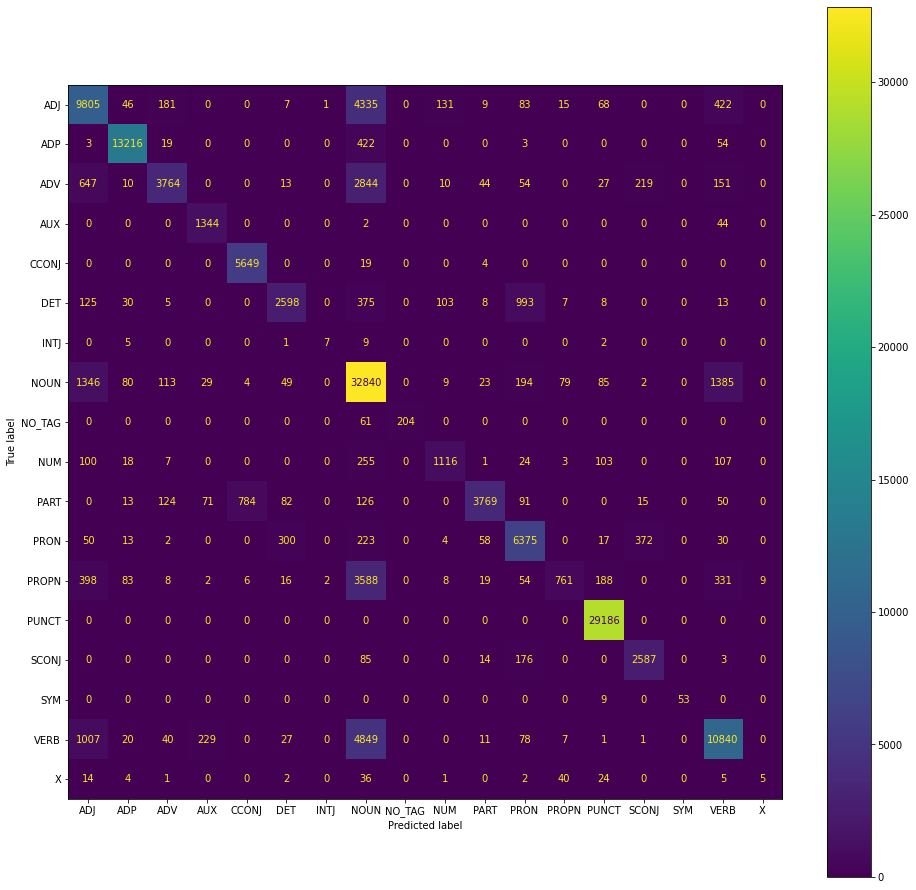

In [ ]:
conf_matrix = confusion_matrix(test_enc_labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()

Достаточно хорошие результаты

Попробуем теперь векторайзер на полных словах (от 1 до 3)

In [ ]:
hvectorizer = HashingVectorizer(ngram_range=(1, 3), analyzer='word', n_features=100)

In [ ]:
X_train = hvectorizer.fit_transform(train_tok)
X_test = hvectorizer.transform(test_tok)

X_train.shape

(426182, 100)

In [ ]:
xgb_model.fit(X_train, train_enc_labels)

XGBClassifier(objective='multi:softprob')

In [ ]:
pred = xgb_model.predict(X_test)
print(classification_report(test_enc_labels, pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.35      0.02      0.04     15103
           1       0.60      0.37      0.46     13717
           2       0.38      0.13      0.19      7783
           3       0.33      0.34      0.33      1390
           4       0.42      0.17      0.24      5672
           5       1.00      0.01      0.03      4265
           6       0.00      0.00      0.00        24
           7       0.25      0.86      0.39     36238
           8       0.00      0.00      0.00       265
           9       0.00      0.00      0.00      1734
          10       0.64      0.54      0.58      5125
          11       0.54      0.29      0.37      7444
          12       0.00      0.00      0.00      5473
          13       0.00      0.00      0.00     29186
          14       0.55      0.70      0.62      2865
          15       0.00      0.00      0.00        62
          16       0.30      0.03      0.05     17110
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


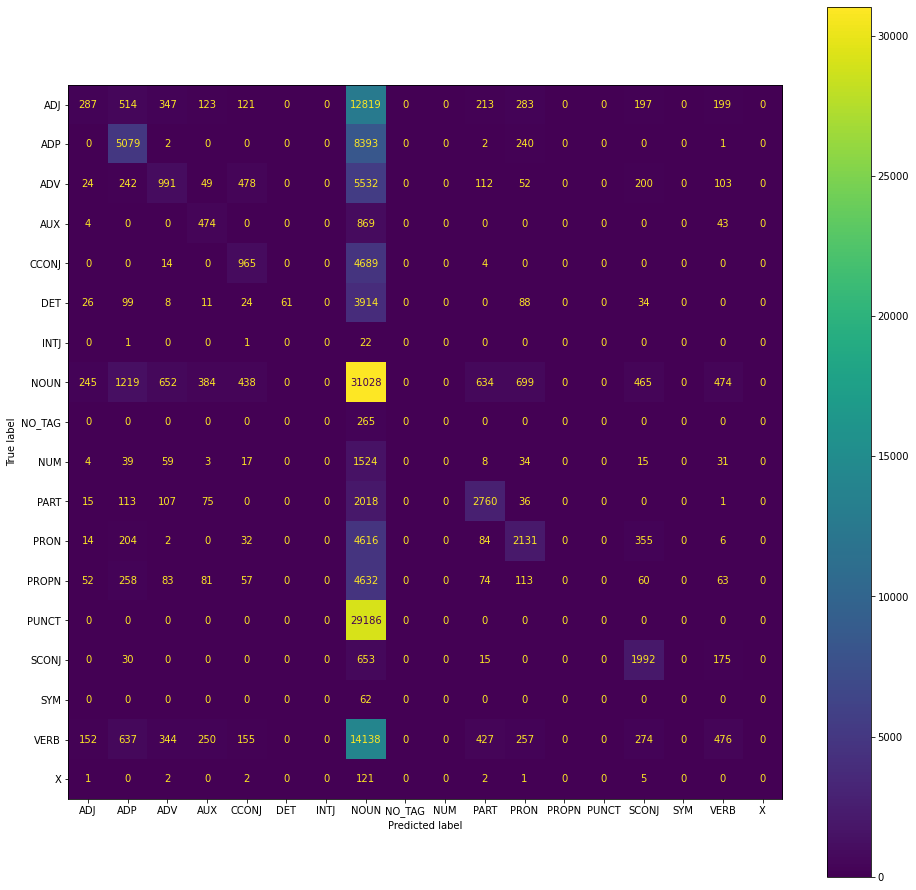

In [ ]:
conf_matrix = confusion_matrix(test_enc_labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()

С полными словами результат гораздо хуже

#Задание 2. Проверить насколько хорошо работает NER
данные брать из http://www.labinform.ru/pub/named_entities/

1. проверить NER из nltk/spacy

2. написать свой нер попробовать разные подходы

а) передаём в сетку токен и его соседей

б) передаём в сетку только токен

в) свой вариант

3. сравнить ваши реализованные подходы на качество (вывести precision/recall/f1_score)


##Начнем с NLTK

In [ ]:
!pip install corus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 1.3 MB/s 


In [ ]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget http://www.labinform.ru/pub/named_entities/collection5.zip

--2022-06-24 03:27:11--  http://www.labinform.ru/pub/named_entities/collection5.zip
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1899530 (1.8M) [application/zip]
Saving to: ‘collection5.zip’

collection5.zip     100%[===================>]   1.81M   872KB/s    in 2.1s    

2022-06-24 03:27:14 (872 KB/s) - ‘collection5.zip’ saved [1899530/1899530]



In [ ]:
!unzip collection5.zip

Archive:  collection5.zip
   creating: Collection5/
  inflating: Collection5/001.ann     
  inflating: Collection5/001.txt     
  inflating: Collection5/002.ann     
  inflating: Collection5/002.txt     
  inflating: Collection5/003.ann     
  inflating: Collection5/003.txt     
  inflating: Collection5/004.ann     
  inflating: Collection5/004.txt     
  inflating: Collection5/005.ann     
  inflating: Collection5/005.txt     
  inflating: Collection5/006.ann     
  inflating: Collection5/006.txt     
  inflating: Collection5/007.ann     
  inflating: Collection5/007.txt     
  inflating: Collection5/008.ann     
  inflating: Collection5/008.txt     
  inflating: Collection5/009.ann     
  inflating: Collection5/009.txt     
  inflating: Collection5/010.ann     
  inflating: Collection5/010.txt     
  inflating: Collection5/011.ann     
  inflating: Collection5/011.txt     
  inflating: Collection5/012.ann     
  inflating: Collection5/012.txt     
  inflating: Collection5/013.ann    

In [ ]:
from corus import load_ne5

path_coll5 = 'Collection5/'
records = load_ne5(path_coll5)
#next(records)

In [ ]:
from razdel import tokenize

#Создаем список из пар [токен - сущность]

In [ ]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

Переводим данные в датафрейм

In [ ]:
import pandas as pd

df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])
df_words['tag'].value_counts()

OUT         219214
PER          21200
ORG          13651
LOC           4568
GEOPOLIT      4356
MEDIA         2482
Name: tag, dtype: int64

In [ ]:
df_words.shape

(265471, 2)

Создадим список только из токенов

In [ ]:
words_list = []
for word in words_docs:
    words_list.append(word[0])

words_list[:10]

['Телеведущий',
 'А',
 '.',
 'Пиманов',
 'стал',
 'сенатором',
 'от',
 'парламента',
 'Тувы',
 '.']

Тегируем POS слова из списка

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

nltk_pos_tags = nltk.pos_tag(words_list)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Теперь ищем среди них именованные сущности

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

chunks = nltk.ne_chunk(nltk_pos_tags, binary=False)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
len(words_list)

265471

Собираем датафрейм из токенов и сущностей после обработки NLTK NER

In [ ]:
pos_tag = nltk.pos_tag(words_list)
chunk = nltk.ne_chunk(pos_tag, binary=False)  
entities = []
labels = []
for chunk in chunks:
    if hasattr(chunk, 'label'):
        for c in chunk:
            entities.append(c[0])
            labels.append(chunk.label())
    else:
        entities.append(chunk[0])
        labels.append('OUT')

In [ ]:
entities_labels = list(zip(entities, labels))
entities_df = pd.DataFrame(entities_labels, columns = ['Entities', 'Labels'])
entities_df

,Entities,Labels
0,Телеведущий,OUT
1,А,OUT
2,.,OUT
3,Пиманов,OUT
4,стал,OUT
...,...,...
265466,стране,OUT
265467,началась,OUT
265468,эпидемия,OUT
265469,холеры,OUT


Добавляем в изначальный датафрейм столбец с результатами работы NER NLTK

In [ ]:
df_words['nltk_ner'] = entities_df['Labels']
df_words

,word,tag,nltk_ner
0,Телеведущий,OUT,OUT
1,А,PER,OUT
2,.,PER,OUT
3,Пиманов,PER,OUT
4,стал,OUT,OUT
...,...,...,...
265466,стране,OUT,OUT
265467,началась,OUT,OUT
265468,эпидемия,OUT,OUT
265469,холеры,OUT,OUT


Смотрим на названия именованных сущностей в столбцах

In [ ]:
df_words['nltk_ner'].unique()

array(['OUT', 'ORGANIZATION', 'PERSON', 'GPE', 'GSP', 'FACILITY'],
      dtype=object)

In [ ]:
df_words['tag'].unique()

array(['OUT', 'PER', 'LOC', 'ORG', 'MEDIA', 'GEOPOLIT'], dtype=object)

Создадим функцию для подсчета метрик

In [ ]:
def ner_metrics(df, true_tag, ner_tag, column_name_1, column_name_2):
    right = 0
    fault = 0
    fault_2 = 0

    for index, person in  df.iterrows():
        if (person[column_name_1] == true_tag) & (person[column_name_2] == ner_tag):
            right += 1
        elif (person[column_name_1] == true_tag) & (person[column_name_2] !=  ner_tag):
            fault += 1
        elif (person[column_name_1] != true_tag) & (person[column_name_2] ==  ner_tag):
            fault_2 += 1
    precision = right / (right+fault_2)
    recall = right / (right+fault)
    f1 = (2*precision*recall) / (precision+recall)
    return print(f'precision = {precision}, recall = {recall}, f1_score = {f1}') 

Метрики по сущности PERSON

In [ ]:
ner_metrics(df_words, 'PER', 'PERSON', 'tag', 'nltk_ner')

precision = 0.5960947503201024, recall = 0.43919811320754715, f1_score = 0.5057577403585007


Метрики по сущности ORG

In [ ]:
ner_metrics(df_words, 'ORG', 'ORGANIZATION', 'tag', 'nltk_ner')

precision = 0.36108637577916297, recall = 0.05940956706468391, f1_score = 0.10203182990501351


## Spacy

In [ ]:
!python -m spacy download ru_core_news_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.9 MB 1.3 MB/s 
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 9.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


Т.к. дефолтный токенайзер в spacy бьет текст на другие токены, чем в tokenizer от razdel, решил использовать ner spacy для потокенной оценки сущностей. Не очень эффективно, но зато можно будет оценить метрики

In [ ]:
import spacy

nlp = spacy.load('ru_core_news_md')

labels=[]
i=0
for word in words_list:
    spacy_ner = nlp(word)
    if spacy_ner.__getitem__(0).ent_type_ == '':
        labels.append('OUT')
    else:
        labels.append(spacy_ner.__getitem__(0).ent_type_)
    i+=1
    if (i % 10000) == 0:
        print(f'обработано {i} слов')

обработано 10000 слов
обработано 20000 слов
обработано 30000 слов
обработано 40000 слов
обработано 50000 слов
обработано 60000 слов
обработано 70000 слов
обработано 80000 слов
обработано 90000 слов
обработано 100000 слов
обработано 110000 слов
обработано 120000 слов
обработано 130000 слов
обработано 140000 слов
обработано 150000 слов
обработано 160000 слов
обработано 170000 слов
обработано 180000 слов
обработано 190000 слов
обработано 200000 слов
обработано 210000 слов
обработано 220000 слов
обработано 230000 слов
обработано 240000 слов
обработано 250000 слов
обработано 260000 слов


In [ ]:
len(labels)

265471

In [ ]:
df_words['spacy_ner'] = labels

Добавляем в базовый датафрейм столбец с предсказаниями ner spacy

In [ ]:
df_words

,word,tag,nltk_ner,spacy_ner
0,Телеведущий,OUT,OUT,OUT
1,А,PER,OUT,OUT
2,.,PER,OUT,OUT
3,Пиманов,PER,OUT,OUT
4,стал,OUT,OUT,OUT
...,...,...,...,...
265466,стране,OUT,OUT,OUT
265467,началась,OUT,OUT,OUT
265468,эпидемия,OUT,OUT,OUT
265469,холеры,OUT,OUT,OUT


Метрики  для сущности PERSON

In [ ]:
ner_metrics(df_words, 'PER', 'PER', 'tag', 'spacy_ner')

precision = 0.9780667701863354, recall = 0.23768867924528303, f1_score = 0.382437765634487


Метрики  для сущности ORG

In [ ]:
ner_metrics(df_words, 'ORG', 'ORG', 'tag', 'spacy_ner')

precision = 0.7811268258752608, recall = 0.2467951065855981, f1_score = 0.37508350033400134


Метрики  для сущности LOC

In [ ]:
ner_metrics(df_words, 'LOC', 'LOC', 'tag', 'spacy_ner')

precision = 0.19749596122778676, recall = 0.21409807355516638, f1_score = 0.20546218487394957


Как и у nltk результат достаточно слайбы, но более стабильный по разным типам сущностей. Слабый результат скорее всего связан с потокенной оценкой.

2. написать свой нер попробовать разные подходы

а) передаём в сетку токен и его соседей

б) передаём в сетку только токен

в) свой вариант

In [ ]:
!wget http://www.labinform.ru/pub/named_entities/collection5.zip

--2022-06-25 07:40:26--  http://www.labinform.ru/pub/named_entities/collection5.zip
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1899530 (1.8M) [application/zip]
Saving to: ‘collection5.zip’

collection5.zip     100%[===================>]   1.81M  2.30MB/s    in 0.8s    

2022-06-25 07:40:27 (2.30 MB/s) - ‘collection5.zip’ saved [1899530/1899530]



In [ ]:
!pip install corus
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip collection5.zip

Archive:  collection5.zip
   creating: Collection5/
  inflating: Collection5/001.ann     
  inflating: Collection5/001.txt     
  inflating: Collection5/002.ann     
  inflating: Collection5/002.txt     
  inflating: Collection5/003.ann     
  inflating: Collection5/003.txt     
  inflating: Collection5/004.ann     
  inflating: Collection5/004.txt     
  inflating: Collection5/005.ann     
  inflating: Collection5/005.txt     
  inflating: Collection5/006.ann     
  inflating: Collection5/006.txt     
  inflating: Collection5/007.ann     
  inflating: Collection5/007.txt     
  inflating: Collection5/008.ann     
  inflating: Collection5/008.txt     
  inflating: Collection5/009.ann     
  inflating: Collection5/009.txt     
  inflating: Collection5/010.ann     
  inflating: Collection5/010.txt     
  inflating: Collection5/011.ann     
  inflating: Collection5/011.txt     
  inflating: Collection5/012.ann     
  inflating: Collection5/012.txt     
  inflating: Collection5/013.ann    

In [23]:
from corus import load_ne5
from razdel import tokenize

dir = 'Collection5/'
records = load_ne5(dir)

Создаем список с парами Токен-Сущность

In [24]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [26]:
words_docs[:5]

[['Спецподкомитет', 'OUT'],
 ['ТПП', 'ORG'],
 ['изучит', 'OUT'],
 ['необходимость', 'OUT'],
 ['создания', 'OUT']]

Преобразуем в датафрейм

In [27]:
import pandas as pd
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])
df_words.head(20)

,word,tag
0,Спецподкомитет,OUT
1,ТПП,ORG
2,изучит,OUT
3,необходимость,OUT
4,создания,OUT
5,госпрограммы,OUT
6,по,OUT
7,развитию,OUT
8,ШПД,OUT
9,.,OUT


In [28]:
df_words['tag'].value_counts()

OUT         219214
PER          21200
ORG          13651
LOC           4568
GEOPOLIT      4356
MEDIA         2482
Name: tag, dtype: int64

In [29]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Разбиваем на обучающую и валидационную выборку

In [50]:
from sklearn import model_selection, preprocessing, linear_model

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words['word'], df_words['tag'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [51]:
train_x.apply(len).max(axis=0)

55

Создаем датасет и батчи

In [53]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

train_data = train_data.batch(128)
valid_data = valid_data.batch(128)

In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
def custom_standardization(input_data):
    return input_data

vocab_size = 50000
seq_len = 30

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    #ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [56]:
len(vectorize_layer.get_vocabulary())

29945

Создаем класс

In [57]:
embedding_dim = 64

class modelNER(tf.keras.Model):
    def __init__(self):
        super(modelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.dp1 = Dropout(0.2)
        self.fc2 = Dense(50, activation='relu')
        self.dp2 = Dropout(0.2)
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)
        
        fc_x = self.fc1(pool_x)
        fc_x = self.dp1(fc_x)
        fc_x = self.fc2(fc_x)
        fc_x = self.dp2(fc_x)
        
        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [68]:
model = modelNER()

In [69]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics='accuracy')

Обучаем 2 эпохи

In [70]:
history = model.fit(train_data, validation_data=valid_data, epochs=2)

Epoch 1/2
1556/1556 [==============================] - 111s 70ms/step - loss: 0.3551 - accuracy: 0.8978 - val_loss: 0.2168 - val_accuracy: 0.9336
Epoch 2/2
1556/1556 [==============================] - 80s 52ms/step - loss: 0.1420 - accuracy: 0.9570 - val_loss: 0.2068 - val_accuracy: 0.9393


In [72]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(valid_x)
y_pred =(y_pred>0.5)

Делаем предсказания

In [73]:
train_pred = model.predict(train_x)
train_pred =(train_pred>0.5)

Выводим отчет

In [74]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [75]:
get_classification_report(train_y, np.argmax(train_pred, axis = 1), valid_y, np.argmax(y_pred, axis = 1))

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.92      0.88      3276
           1       0.88      0.93      0.90      3438
           2       0.95      0.84      0.89      1931
           3       0.92      0.67      0.77     10121
           4       0.97      0.99      0.98    164413
           5       0.98      0.87      0.93     15924

    accuracy                           0.96    199103
   macro avg       0.92      0.87      0.89    199103
weighted avg       0.96      0.96      0.96    199103

TEST

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1080
           1       0.85      0.78      0.81      1130
           2       0.92      0.74      0.82       551
           3       0.87      0.54      0.67      3530
           4       0.94      0.99      0.97     54801
           5       0.97      0.71      0.82      5276

    accuracy                           0.94     66368
   macro a

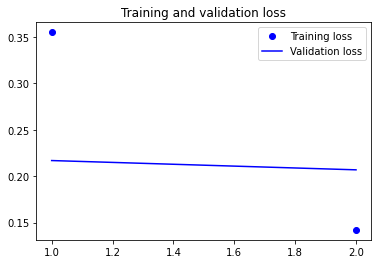

In [76]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs0 = range(1, len(loss) + 1)
plt.plot(epochs0, loss, 'bo', label='Training loss')
plt.plot(epochs0, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Судя по метрикам, вышла достаточно неплохая классификация именованных сущностей, даже лучше, чем nltk и spacy на этом наборе данных.